# Introduction to `pysheds`

In this tutorial, we're going to cover a new Python package one can use to determine the **catchment area**, i.e. the area that drains into a specific point, and resource of a potential run-of-river power plant based on a digital elevation model (DEM), i.e. a raster representation of elevation.

**pysheds: Simple and fast watershed delineation in python**

> Pysheds is an open-source library designed to help with processing of digital elevation models (DEMs), particularly for hydrologic analysis. Pysheds performs many of the basic hydrologic functions, including catchment delineation and accumulation computation.

:::{note}
Documentation for `pysheds` is available at http://mattbartos.com/pysheds/.
:::

:::{note}
If you have not yet set up Python on your computer, you can execute this tutorial in your browser via [Google Colab](https://colab.research.google.com/). Click on the rocket in the top right corner and launch "Colab". If that doesn't work download the `.ipynb` file and import it in [Google Colab](https://colab.research.google.com/).

Then install the following packages by executing the following command in a Jupyter cell at the top of the notebook.

```sh
!pip install pysheds matplotlib
```
:::

:::{note}
The following tutorial is based on the following resources:
- http://mattbartos.com/pysheds/
- [https://medium.com/@ilmachairas/basin-delineation-on-python](https://medium.com/@ilmachairas/basin-delineation-on-python-**5e9da00a3534**)
:::

## Data Downloads

Before we can run this tutorial, we have to download a few input data files to your local filesystem. The cell below uses some Python utility packages to automate the retrieval of the required files.

In [35]:
from urllib.request import urlretrieve
from os.path import basename

url = "https://tubcloud.tu-berlin.de/s/ZPiZjX3Nzc6R6RX/download/output_COP30.tif"
urlretrieve(url, basename(url));

## Imports

First, let's bring in the `Grid` class from the `pysheds` library, which will be our primary data structure for managing and analyzing grid-based spatial data like elevation models in our hydrological computations:

In [80]:
from pysheds.grid import Grid

We will also need a few additional Python packages known from previous tutorials:

In [81]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature

## Reading Digital Elevation Models (DEM)

A **Digital Elevation Model (DEM)** is a 3D representation of a terrain's surface created from terrain elevation data, and it's the main dataset we'll read into our analysis to model the watershed's topography. It consists of a grid of cells, each containing an elevation value that represents the height of the terrain at that specific location.

For this example, data for a small part of Northern Portugal is taken from the [Copernicus Global Digital Elevation Model](https://doi.org/10.5069/G9028PQB), which offers global coverage at a resolution of 30 metres.

In [82]:
fn = "output_COP30.tif"
grid = Grid.from_raster(fn, nodata=0)
dem = grid.read_raster(fn, nodata=0)

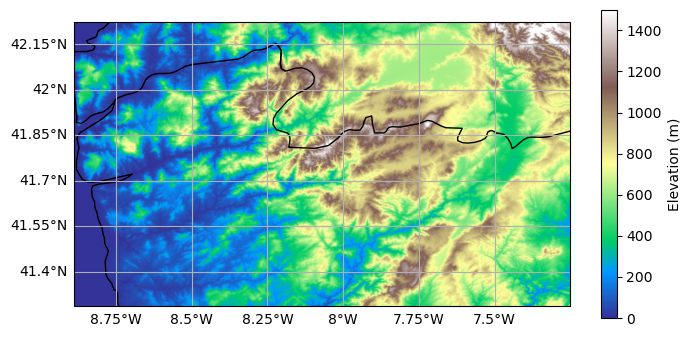

In [83]:
fig = plt.figure(figsize=(8, 4))
ax = plt.axes(projection=ccrs.PlateCarree())
plt.imshow(dem, extent=grid.extent, cmap="terrain", vmin=0, vmax=1500)
plt.colorbar(label="Elevation (m)")
ax.coastlines()
ax.add_feature(cfeature.BORDERS)
ax.gridlines(draw_labels=['bottom', 'left']);

## Conditioning the elevation data

Raw DEMs often contain artifacts (such as pits, depressions and flat regions) that prevent the DEM from fully draining. Full drainage, i.e. the ability for water to flow from any cell to the edge of the DEM, is a prerequisite for hydrological analysis.

- **Pits** consist of single cells for which every surrounding cell is at a higher elevation.
- **Depressions** consist of groups of cells for which every surrounding cell is at a higher elevation.
- **Flats** consist of cells at which every surrounding cell is at the same elevation or higher.

The presence of pits, depressions and flats means that water will aggregate there and would not move downwards. This would be unrealistic in most natural terrains, because water would eventually find a way to flow out of such areas, either by overflowing or by eroding a channel.

Therefore, these artifacts need to be removed before the datasets can be used. By applying the following code, the affected pixels will get the values of their surrounding ones, so that water can flow through them. This process is called **filling** the DEM. Filling depressions is more computationally intensive than filling pits.

In [84]:
pit_filled_dem = grid.fill_pits(dem)

In [85]:
flooded_dem = grid.fill_depressions(pit_filled_dem)

In [86]:
conditioned_dem = grid.resolve_flats(flooded_dem)

After conditioning the data by filling depressions and resolving flats, the **flow direction** can be determined, which indicates the direction water would flow out of each cell based on the surrounding elevations.

## Computing flow directions

Flow directions are computed to capture the topology of the drainage network,
and are needed for delineating catchment areas and computing the **accumulation** of
flow. The accumulation measures how many upstream cells drain into each cell. 

By default, `pysheds` will compute flow directions using the D8 routing
scheme (ESRI). In this routing mode, each cell is routed to one of eight
neighboring cells based on the direction of steepest descent:

- **North:** 64
- **Northeast:** 128
- **East:** 1
- **Southeast:** 2
- **South:** 4
- **Southwest:** 8
- **West:** 16
- **Northwest:** 32

The D8 algorithm is simple and computationally efficient, but other algorithms exist.
It is called using the `flowdir` method of the `Grid` class.

In [87]:
flowdir = grid.flowdir(conditioned_dem)

As you can see, the flow direction values correspond to the D8 scheme described above.

In [88]:
np.unique(flowdir)

Raster([ -2,  -1,   0,   1,   2,   4,   8,  16,  32,  64, 128])

The values -1 and -2 indicate cells where flow direction could not be determined, for example because they are located at the edge of the DEM or in pits or flats that were not resolved during the conditioning step.

Plotting the flow directions with `imshow` gives a 3D-like impression of the terrain (like a hillshade), because the flow directions indicate the steepest descent directions.

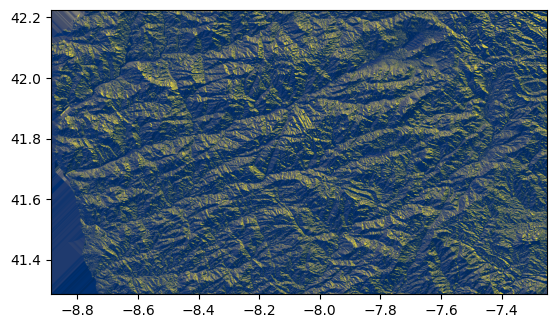

In [89]:
plt.imshow(flowdir, extent=grid.extent, cmap="cividis");

## Computing flow accumulation

The **accumulated flow** is the number of upstream cells that contribute flow to each cell in the DEM grid. The result of this calculation is a grid where each cell's value represents the count of all cells that flow into it, directly or indirectly. In essence, it gives you an idea of the potential water volume that would pass through each point if each cell contributed a unit amount of water. Of course, in reality, the actual water flow measured for each cell would be used instead of just counting cells.

The flow accumulation process takes the flow direction grid as input and works by tracking the flow from each cell to its downslope neighbors. It aggregates the number of cells flowing into each downslope cell, *accumulating* the flow as it moves through the drainage network. Hence, as you move downstream, the number increases, and the other way around for upstream. This means that cells with high accumulation values are typically located in valleys or channels where water converges from larger areas, while cells with low accumulation values are often found on ridges or higher elevations where less water flows in.

In [90]:
acc = grid.accumulation(flowdir)

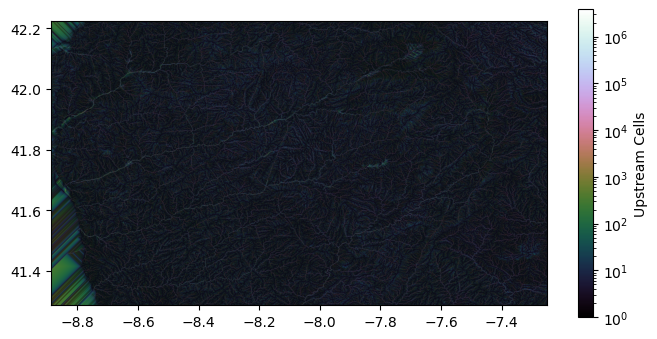

In [91]:
fig, ax = plt.subplots(figsize=(8, 4))
im = ax.imshow(
    acc,
    extent=grid.extent,
    cmap="cubehelix",
    norm=LogNorm(1, acc.max()),
    interpolation="bilinear",
)
plt.colorbar(im, ax=ax, label="Upstream Cells");

## Computing catchment areas

The method to calculate the **catchment area** also operates on the flow direction grid.

To delineate a catchment, first specify a **pour point** (the **outlet** of the catchment area such as the weir of a run-of-river power plant).

However, sometimes the pour point is not known exactly. In this case, it can be helpful to first compute the accumulated flow and then snap a roughly estimated pour point to the nearest high accumulation cell. This way, it is ensured that the pour point is located on a drainage channel.

For instance, we may specify a trial pour point:

In [92]:
x, y = -7.954, 41.47

... then snap the pour point to a high accumulation cell with at least 5000 upstream cells:


In [93]:
x_snap, y_snap = grid.snap_to_mask(acc > 5000, (x, y))

This point, we can then use to delineate the catchment area:

In [94]:
catch = grid.catchment(x=x_snap, y=y_snap, fdir=flowdir, xytype="coordinate")

:::{note}
- If the x and y components of the pour point are spatial coordinates in the grid’s spatial reference system, specify `xytype='coordinate'`.
- If the x and y components of the pour point correspond to the row and column indices of the flow direction array, specify `xytype='index'`.
:::

We can then clip our grid to the catchment area and plot the result:

In [95]:
grid.clip_to(catch)
clipped_catch = grid.view(catch)

In [96]:
clipped_accumulated_flow = grid.accumulation(flowdir)

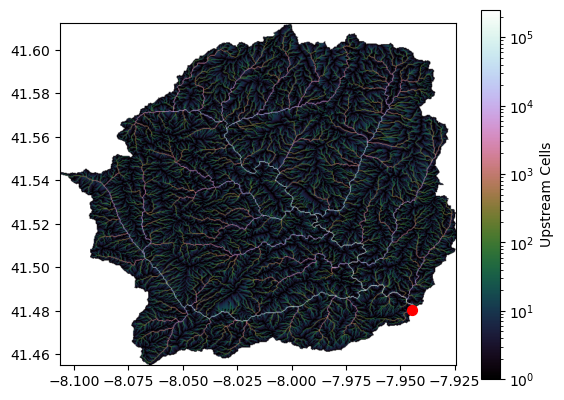

In [97]:
fig, ax = plt.subplots()
im = ax.imshow(
    np.where(clipped_catch, clipped_accumulated_flow, np.nan),
    extent=grid.extent,
    cmap="cubehelix",
    norm=LogNorm(1, clipped_accumulated_flow.max()),
    interpolation="bilinear",
)
plt.colorbar(
    im,
    ax=ax,
    label="Upstream Cells",
)
plt.scatter([x_snap], [y_snap], c="r", s=50)

## Next Steps

**Explore datasets of global hydro basins and what they are used for:**

https://www.hydrosheds.org/

> The HydroSHEDS database offers a suite of global digital data layers in support of hydro-ecological research and applications worldwide. Its various hydrographic data products include catchment boundaries, river networks, and lakes at multiple resolutions and scales.

HydroSHEDS data are freely available in standard GIS formats and form the geospatial framework for a broad range of assessments including hydrological, environmental, conservation, socioeconomic, and human health applications.

https://www.hydrosheds.org/applications/ssp-hydropower

> HydroSHEDS data have been used to assess configuration scenarios for future hydropower development at global, national (e.g., Zambia, Nepal) or basin-level (e.g., Marañón river) scales. This ‘system-scale planning’ (SSP) approach provides a large-scale perspective which considers the complex interactions and cumulative effects of different dam combinations rather than determining the impacts of each dam project individually. This type of holistic assessment takes the regional and downstream effects of the entire hydropower scenario into account and allows for strategic planning by comparing various national or international development options. It is particularly useful during the early phases of hydropower portfolio design and can facilitate the dialog between stakeholders and policymakers as a decision support tool.

**Calculate water flow volume at pour point using meteorological data:**

With the delineated catchment area from `pysheds`, you can utilize [surface runoff](https://codes.ecmwf.int/grib/param-db/?id=8) data, which represents the part of precipitation and snowmelt that flows over the land without infiltrating the soil or evaporating, to estimate total flow at the basin's pour point. By integrating surface runoff data over the entire catchment area, typically given in volume per area per time (e.g. millimetres per day), and summing it up for all the cells within the catchment, you can approximate the total water volume contributing to the flow at the pour point. This integration accounts for spatial variations in runoff generation across the catchment, providing you with an aggregated flow estimate that can be used to assess the hydrological output of the catchment at the specific location where the water exits the basin, for instance, the amount of water available for electricity generation in a run-of-river plant.

## Exercises

**Task 1:** Determine a few additional catchment areas by varying the pour point and the threshold for the accumulated flow.